## Descripcion:
Modulador BPSK solo para simulacion en python

Incluye:
 - Generacion de Señal de datos aleatoria
 - Modulacion bpsk con la posibilidad de usar (rect, rc, rcc)
 - Diagrama de ojo señal a transmitir
 - FFT señal a transmitir
 - Generacion de un portadora y se la modula
 - FFT señal recibida
 - Generacion de Ruido
 - Filtro pasa banda
 - Demodulacion coherente
 - Filtro pasa bajos
 - Diagrama de ojo señal recibida
 - FFT señal recibida
 - Muestreo y umbralizado
 - Grafica BER vs SNR (con correcion por la disminucion de la potencia de ruido debido a los filtros)

Version: 3

## Importamos librerias

In [1]:
#!pip install scikit-dsp-comm

In [2]:
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, lfilter
from scipy.signal import kaiserord, firwin, freqz
from scipy import signal
%matplotlib notebook

## Generamos una señal a transmitir

<IPython.core.display.Javascript object>


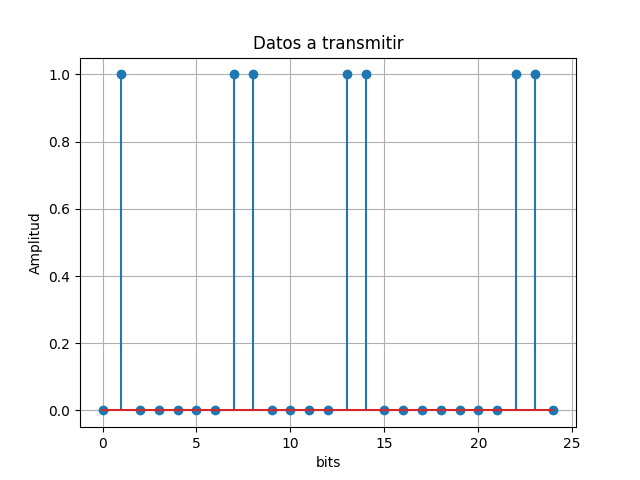

In [3]:
NroBits = 10000    # Numero de bits a transmitir
fs = 10000         # Frecuencia de muestreo [Hz]
ts = 1/fs          # Periodo de muestreo [sec]
Tbit = 0.01        # Tiempo del bit [sec]
Ns = int(fs*Tbit)  # Muestras por bit de dato

TxData = np.random.randint(2,size=NroBits)

plt.figure()
plt.stem(TxData[0:25], use_line_collection=True)
plt.title("Datos a transmitir")
plt.xlabel("bits")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

## Generamos la señal BPSK

<IPython.core.display.Javascript object>


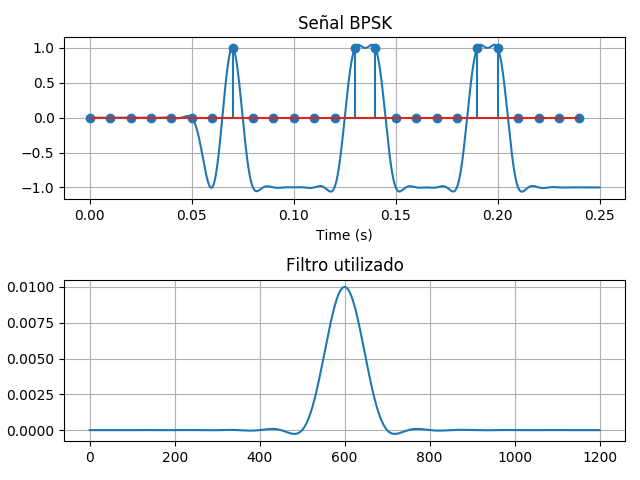

In [4]:
# Parametros para la BPSK
Pulse = 'rc'  # Tipo de filtro a utilizar [rect, rc, rcc]
Alpha = 1     # Parametro alpha del filtro

# Generacion de la BPSK
Signal_NRZ, Pulse_shape = ss.NRZ_bits2(TxData, Ns, pulse=Pulse, alpha=Alpha)
t = np.arange(len(Signal_NRZ))

# Ajuste del retraso generado, solo a fin de poder graficar correctamente
Desfasaje = 6
Aux_TxData = np.zeros(Desfasaje,dtype=int).tolist() + TxData.tolist() 

plt.figure()
plt.subplot(211)
plt.plot(ts*t[0:Ns*25], Signal_NRZ[0:Ns*25])
plt.stem(ts*t[0:Ns*25:Ns], Aux_TxData[0:25], use_line_collection=True)
plt.title("Señal BPSK")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(212)
plt.plot(Pulse_shape)
plt.title("Filtro utilizado")
plt.grid()
plt.tight_layout()
plt.show()

## Diagrama de ojo, señal

<IPython.core.display.Javascript object>


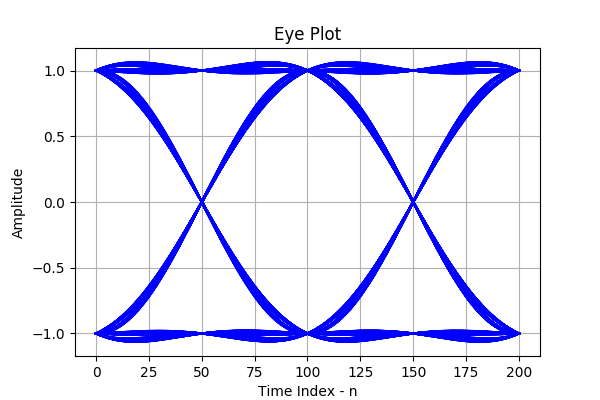

In [5]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(Signal_NRZ[Ns*1000:Ns*2000],L,S)  # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
plt.show()

## FFT, Señal transmitida

<IPython.core.display.Javascript object>


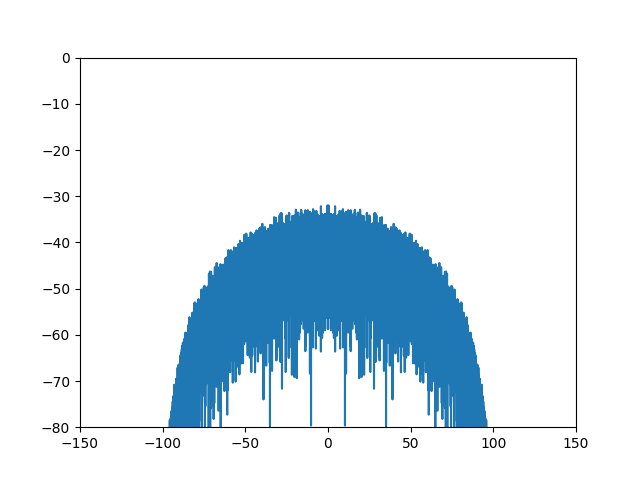

In [6]:
plt.figure()
N = Signal_NRZ.shape[0]
Y = fft(Signal_NRZ)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-int(1/Tbit) - int((1/Tbit)*0.25), int(1/Tbit) + int((1/Tbit)*0.25))
plt.ylim(-80,0)
plt.show()

## Portadora

<IPython.core.display.Javascript object>


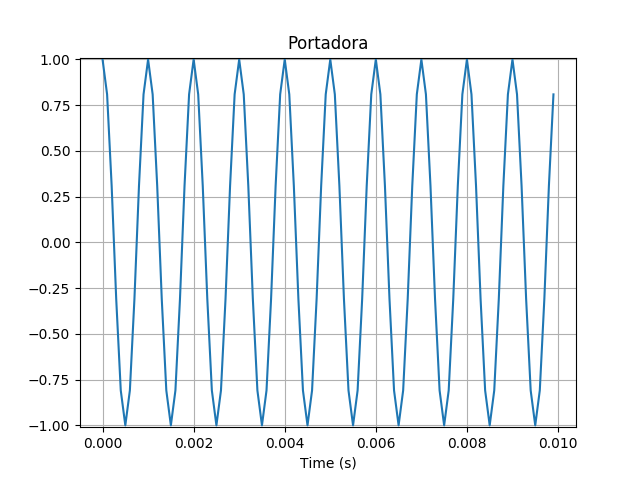

In [7]:
Fc=1000  # [Hz] frecuencia del oscilador local (carrier)

OL = np.cos(2*np.pi*Fc*(t*ts))

plt.figure()
plt.plot(ts*t[0:100], OL[0:100])
plt.ylim([-1.01, 1.01])
plt.title("Portadora")
plt.xlabel('Time (s)')
plt.grid()
plt.show()

## Modulamos la portadora con la señal NRZ

<IPython.core.display.Javascript object>


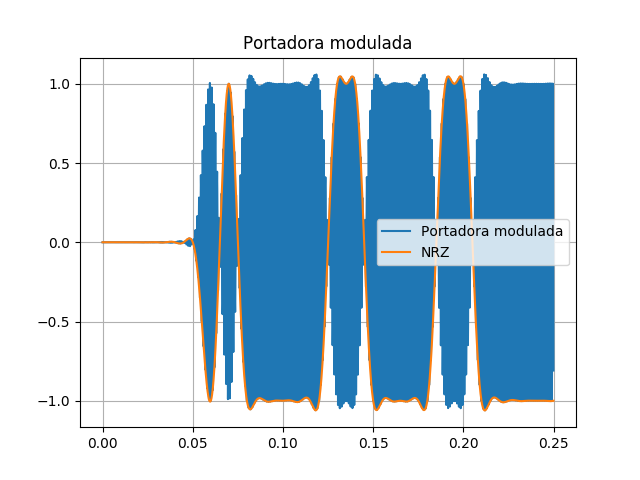

In [8]:
st = Signal_NRZ*OL   # Señal transmitida

plt.figure()
plt.plot(ts*t[0:Ns*25], st[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Signal_NRZ[0:Ns*25])
plt.grid()
plt.title("Portadora modulada")
plt.legend(("Portadora modulada","NRZ"))


## FFT señal modulada

<IPython.core.display.Javascript object>


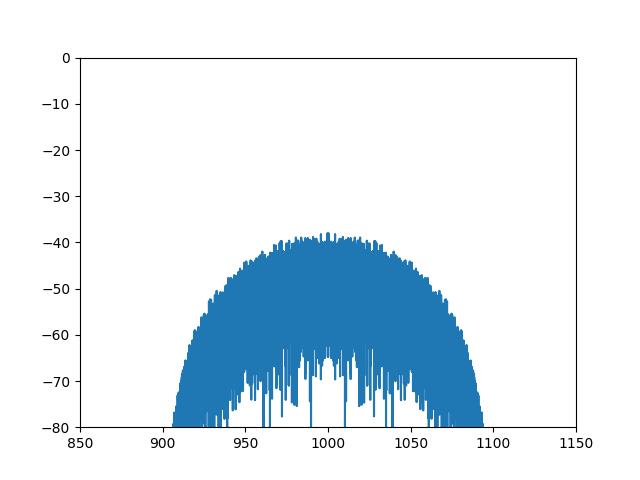

In [9]:
plt.figure()
N = st.shape[0]
Y = fft(st)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(850,1150)
plt.ylim(-80,0)
plt.show()

## Ruido aditivo a la señal modulada

In [10]:
# Ruido gaussiano blanco aditivo

snr = 1 # SNR en [dB]
snr = 10 ** (snr / 10.0)
xpower = np.sum(st ** 2) / len(st)
npower = xpower / snr

noise = np.random.randn(len(st)) * np.sqrt(npower)

st_noise = noise + st

# Verificacion:
npower_check = np.sum(noise**2) / len(noise)
print("nPower_check Tx:", npower_check)
print("nPower Tx:", npower)

nPower_check Tx: 0.2974074949359623
nPower Tx: 0.2974517178587337


## FFT, señal Recibida

<IPython.core.display.Javascript object>


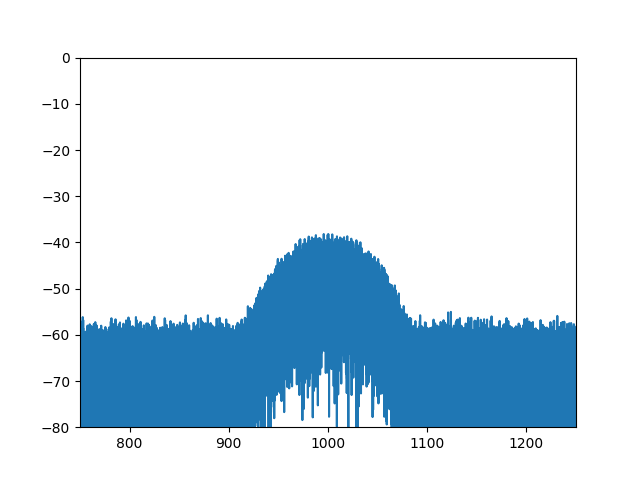

In [11]:
plt.figure()
N = st_noise.shape[0]
Y = fft(st_noise)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(750,1250)
plt.ylim(-80,0)
plt.show()

## Demodulacion

In [12]:
## Filtro pasa banda
nyq = fs/2
low = 850 / nyq
high = 1150 / nyq
order = 5
b, a = butter(order, [low, high], btype='band')
rt = lfilter(b, a, st_noise)

#npower_rx = np.sum(rt**2) / len(rt)
#print("npower_rx:", npower_rx)

<IPython.core.display.Javascript object>


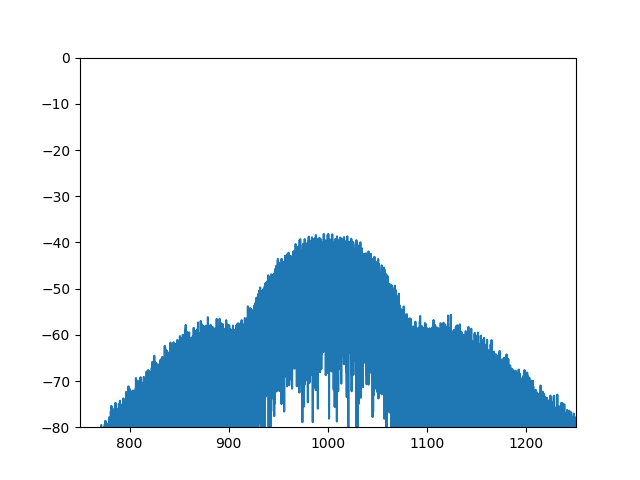

In [13]:
plt.figure()
N = rt.shape[0]
Y = fft(rt)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(750,1250)
plt.ylim(-80,0)
plt.show()

<IPython.core.display.Javascript object>


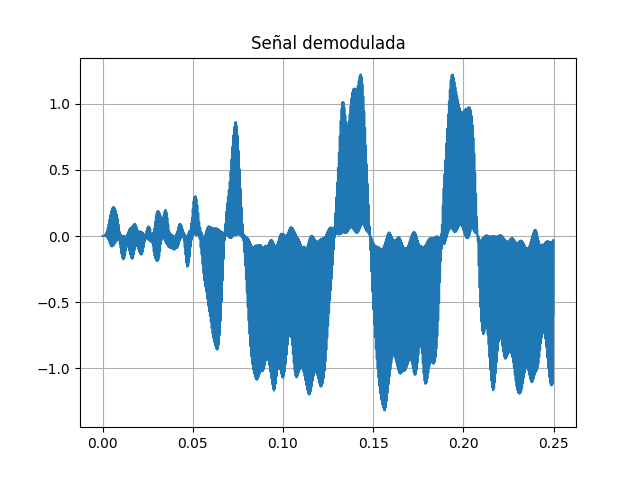

Text(0.5, 1.0, 'Señal demodulada')

In [14]:
# Demudulacion coherente
Signal_NRZ_Rx = rt * OL

plt.figure()
plt.plot(ts*t[0:Ns*25], Signal_NRZ_Rx[0:Ns*25])
plt.grid()
plt.title("Señal demodulada")

## Filtro pasa bajos



<IPython.core.display.Javascript object>


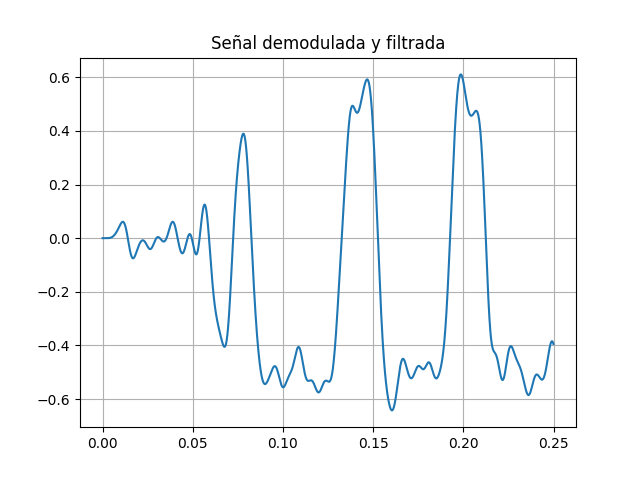

Text(0.5, 1.0, 'Señal demodulada y filtrada')

In [15]:
# Filtro pasa bajos
nyq = fs/2
low = 120 / nyq
order = 5
b, a = butter(order, low, btype='low')
y = lfilter(b, a, Signal_NRZ_Rx)

#npower_rx_demodulado = np.sum(y**2) / len(y)
#print("npower_rx_demodulado:", npower_rx_demodulado)

plt.figure()
plt.plot(ts*t[0:Ns*25], y[0:Ns*25])
plt.grid()
plt.title("Señal demodulada y filtrada")

## Diagrama de ojo, señal demodulada

<IPython.core.display.Javascript object>


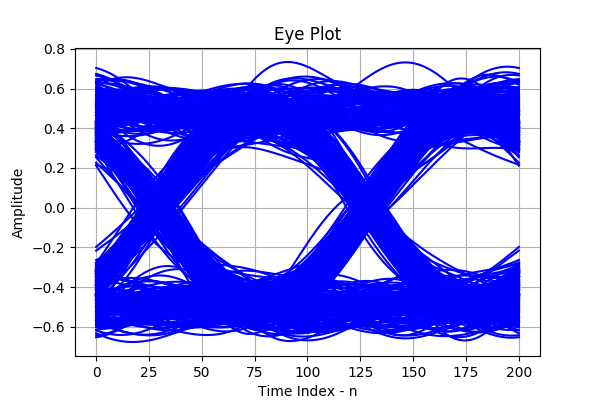

In [16]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(y[Ns*1000:Ns*2000],L,S) # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
plt.show()

## FFT, señal demodulada

<IPython.core.display.Javascript object>


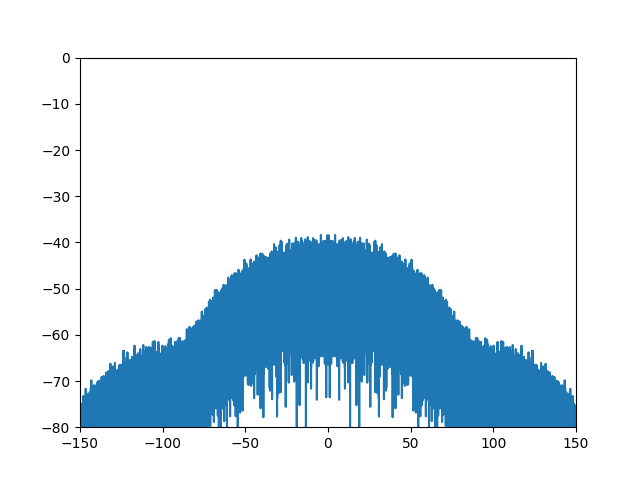

In [17]:
plt.figure()
N = y.shape[0]
Y = fft(y)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-150,150)
plt.ylim(-80,0)
plt.show()

## Muestreo y umbralizado

<IPython.core.display.Javascript object>


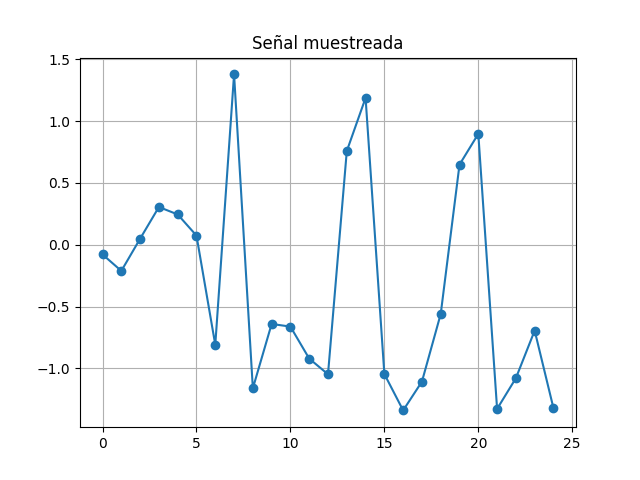

Todos los bits recibidos son iguales a los transmitidos
BER:  0.0


In [21]:
# Centro del diagrama de ojo:
Eye_center = 75
ys = y[Eye_center::Ns] 

plt.figure()
plt.plot(ys[0:25], '-o')
plt.grid()
plt.title("Señal muestreada")

# Umbralizado
RxData = 1*(ys > 0)

# Verificacion de bits recibidos
if ((TxData[:-Desfasaje]==RxData[Desfasaje:]).all()):
    print("Todos los bits recibidos son iguales a los transmitidos")
else:
    print("Los bits recibidos no son iguales a los transmitidos")
    
# Calculo del BER
ber = np.sum(np.abs(RxData[Desfasaje:] - TxData[:-Desfasaje]))/len(TxData[:-Desfasaje])
print("BER: ",ber)

## BER vs SNR

In [22]:
SNRs = np.linspace(-20,-5,40) 
BERs = []

for i, snr_i in enumerate(SNRs):
    # Ruido gaussiano blanco aditivo
    snr_db = snr_i # SNR en [dB]
    snr = 10 ** (snr_db / 10.0)
    xpower = np.sum(st**2) / len(st)
    npower = xpower / snr
    st_noise = np.random.randn(len(st)) * np.sqrt(npower) + st
    print("\nSNR: " + str(snr_db))
    print("xpower: " + str(xpower))
    print("npower: " + str(npower))

    ## Filtro pasa banda
    nyq = fs/2
    low = 850 / nyq
    high = 1150 / nyq
    order = 5
    b, a = butter(order, [low, high], btype='band')
    rt = lfilter(b, a, st_noise)

    # Demudulacion coherente
    Signal_NRZ_Rx = rt * OL*2


    # Filtro pasa bajos
    nyq = fs/2
    low = 120 / nyq
    order = 5
    b, a = butter(order, low, btype='low')
    y = lfilter(b, a, Signal_NRZ_Rx)

    # Diagrama de ojo
    L = Ns*2        # display length in samples (usually two symbols)
    S = 0           # start index
    #dc.eye_plot(y[Ns*1000:Ns*2000],L,S)
    plt.show()

    # Muestreo
    Eye_center = 75
    ys = y[Eye_center::Ns] 

    # Umbralizado
    RxData = 1*(ys > 0)

    # Calculo del BER
    ber = np.sum(np.abs(RxData[Desfasaje:] - TxData[:-Desfasaje]))/len(TxData[:-Desfasaje])
    BERs.append(ber)
    print("BER: " + str(ber))



SNR: -20.0
xpower: 0.3744695263941888
npower: 37.446952639418875
BER: 0.23574144486692014

SNR: -19.615384615384617
xpower: 0.3744695263941888
npower: 34.27322270378108
BER: 0.2154292575545327

SNR: -19.23076923076923
xpower: 0.3744695263941888
npower: 31.368474914737487
BER: 0.20972583550130078

SNR: -18.846153846153847
xpower: 0.3744695263941888
npower: 28.70991231203833
BER: 0.20422253352011208

SNR: -18.46153846153846
xpower: 0.3744695263941888
npower: 26.276670039118716
BER: 0.1874124474684811

SNR: -18.076923076923077
xpower: 0.3744695263941888
npower: 24.04965159211587
BER: 0.18200920552331398

SNR: -17.692307692307693
xpower: 0.3744695263941888
npower: 22.011378947222173
BER: 0.16629977986792074

SNR: -17.307692307692307
xpower: 0.3744695263941888
npower: 20.145855390148252
BER: 0.1549929957974785

SNR: -16.923076923076923
xpower: 0.3744695263941888
npower: 18.438439971157944
BER: 0.1502901741044627

SNR: -16.53846153846154
xpower: 0.3744695263941888
npower: 16.875732600376477

<IPython.core.display.Javascript object>


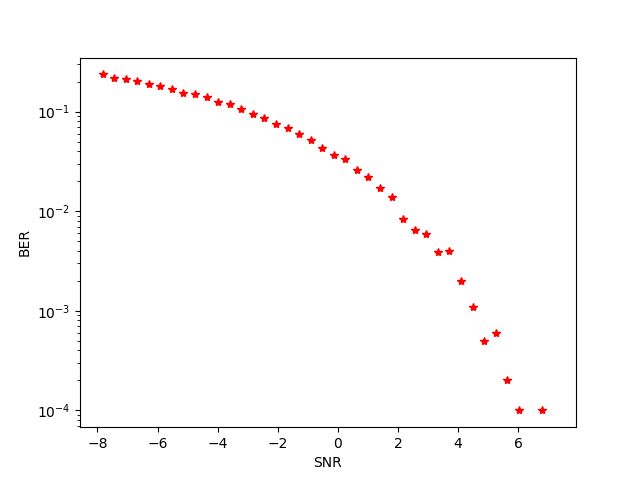

In [23]:
# Correccion
#npower_tx: 0.2973103837660191
#npower_rx: 0.0180414986077511
#npower_rx_demodulado: 0.003505769909250549

# El nivel de ruido se reduce = 10*np.log10(0.0180414986077511/0.2973103837660191) [db] debido a los filtros
snr_offset = 10*np.log10(0.0180414986077511/0.2973103837660191)
SNRs_fix = SNRs - snr_offset


#Plot
plt.figure()
plt.plot(SNRs_fix,BERs,'*r')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('BER')
plt.show()